# Explainer Notebook
02850 - Social Data Analysis and Visualizations

## 1 - Introduction (Motivation)
We have chosen to perform a data analysis using data from the London Fire Brigade (LFB) combined with external data  regarding available London from the internet. 

### 1.1 Datasets
The used data is listed below along with links to the original sources and a brief description.

#### Dataset1: London Fire Brigade Incident Records (January 2013 to December 2016) 
Contains all incidents registered in the LFB system from January 2013 to December 2016. The dataset is public available at: https://data.london.gov.uk/dataset/london-fire-brigade-incident-records. There are 3 types of incidents; Fire, False Alarm and Special Incidents (e.g. Floodings, fire inspections, and so on). The data contains 404009 incidents and the file size is approximately 100Mb (10mb if compressed). The dataset contains 30 attributes of which we have chosen to work on a only a subset listed below

- Incident Number: The number given to the incident in their internal system. This is only used in order to combine the dataset with London Mobilisation Records (see below). 
- Time of Call: hour, minute, and seconds of call
- Date of Call: self-explanetory
- Incident Group: Can be either fire, false alarm or special incident. 
- Fire station ground: The fire station which the location is connected to.
- Attendance Time: Time used at the incident location
- Easting_rounded: British National Grid (BNG) six figure number determining location (see https://www.ordnancesurvey.co.uk/support/the-national-grid.html for more info on the BNG system)
- Northing_rounded: Same as above
- Borough Name: This is actually not exactly the borough, but the local authority which in some cases are two boroughs combined

#### Dataset2: London Fire Brigade Mobilisation Records (January 2013 to December 2016)
This dataset contains mobilization information about the firetrucks/fireunits. The dataset is publically available at: https://data.london.gov.uk/dataset/london-fire-brigade-mobilisation-records The dataset is approximatly 80mb in XLXS format. The dataset is used in order to calculate the time it takes the LFB to arrive at the incident location. The dataset contains 22 attributes, but some of them overlap with the previously mentioned dataset. We only use the following

- Incident Number: The number given to the incident in their internal system. This is the link between these records and the records from the above dataset. 
- Time Mobilised: The time the vehicle starts to move.
- Time Arrived: The Arrival time at the incident. 

#### Dataset3: Temperature Data
Weather information about London from January 2013 to December 2016 extracted from Nation Centers for Environmental Information (NCEI) data service (https://www.ncdc.noaa.gov/). We use the average temperature for a given day, hence we have approximetly 365*4 observations in the dataset. 

#### Dataset4: Dwelling Data
Information about boroughs in contrast to dwellings(buildings) and population. The dataset is publically available at: https://data.london.gov.uk/dataset/net-additional-dwellings-borough


#### Dataset5: Wikipedia
We manually information about the area sizes of boroughs from wikipedia. LINK: https://en.wikipedia.org/wiki/List_of_London_boroughs

#### Dataset6: Fire station locations
Based on the fire stations in the dataset, we manually extracted locations of all 57 fire stations servicing Inner London. The coordinates can be found at: http://www.london-fire.gov.uk/150/map-of-london-fire-stations.asp

All of these datasets have been used throughout our analysis. We will explain a lot more about the pre-processing needed to combine the data in section 2. 

### 1.2 Motivation
We looked at a lot of different datasets in order to finally go with LFB. We thought that combining the dataset with other data, we could find some interesting facts about fires that potentially could help the London Fire Brigade. 

Initially we thought that weather data and population density information could be correlated with the amount of fires in a certain area, or at a certain day. Furthermore, we thought that it perhaps was possible to find spurious correlations in the data, which could be fun to illustrate. The rest of the data has been collected after the implementing part began, since we needed the data for some fun concepts. 

At last, we just genuinely liked the data which contains incidents with coordinates and categories. Hence we thought that the data was an obvious fit to machine learning and cool visualizations. 

### 1.3 Goal
Our goal for this project is to create a website that shows all of our most interesting findings. We hope that the website will be useful and fun for the LFB to look at. The goal for the website is that it should tell a story of how the massive amount of data which the LFB collects can be visualized in order to gain insights that are impossible to learn without data scientists. Furthermore, we hope to find correlations between external data which they are not aware of. 

The dream scenario is of course that the LFB calls us because our findings are so interesting that they want to hire us as data science consultants! 

## 2 - Basic stats

### 2.1 Loading the Data
For loading data, we have extensively used the DataFrame object from pandas. The Date from the incidents is in a quite weird format (i.e. 01-Jan-13) and we therefore create a converter when loading (which is actually part of preprocessing). 

In [70]:
%matplotlib inline
%matplotlib nbagg
import pandas as pd
import numpy as np

# For converting to correct time stamp
month_converter = {"Jan": "01",
                   "Feb": "02",
                   "Mar": "03",
                   "Apr": "04",
                   "May": "05",
                   "Jun": "06",
                   "Jul": "07",
                   "Aug": "08",
                   "Sep": "09",
                   "Oct": "10",
                   "Nov": "11",
                   "Dec": "12",
                   }

def date_converter(value):
    split = value.split("-")
    date_string = "20" + split[2] + month_converter[split[1]] + split[0]
    return int(date_string)

converter = {'DateOfCall': lambda x: date_converter(x)}

df = pd.read_csv("../data/incidents.csv", header=0, converters=converter)
# To print the attributes uncomment below
# print list(df)


### 2.2 Preprocessing 
This is a particular important part of data analysis. We will explain all of the pre-processing steps that we have performed. The borough names are sometimes lower cased and sometimes uppercased. We convert all of them to lower case. 

In [71]:
df["IncGeo_BoroughName"] = df.apply(lambda x: x["IncGeo_BoroughName"].lower(), axis=1)

We now discard all of the attributes that are not used in this notebook. Note that we have analysed all of the attributes and are not just throwing away data that potentially could be usefull.

In [72]:
relevant_attributes = ["IncidentNumber", "TimeOfCall", "IncidentGroup",
                       "IncidentStationGround", "FirstPumpArriving_AttendanceTime",
                       "IncGeo_BoroughName", "DateOfCall", "Easting_rounded", "Northing_rounded"]
# Simplicity <3 
df = df[relevant_attributes]

Next step is to convert the GNB Eastings and Northings to lattitude and Longitude. Luckily, we found a python library that can do this (convertbng). The dataset contained a lot of erounous values in the Easting and Northing, hence we ended up discarding data where no location was available. 

In [73]:
from convertbng.util import convert_lonlat

def canBeFloat(entry):
        try:
            float(entry)
            return True
        except:
            return False

# filter out values that are not float values
df = df[df.apply(lambda x: canBeFloat(x["Easting_rounded"]), axis=1)]


lon, lat = convert_lonlat(df["Easting_rounded"].astype(float).tolist(), df["Northing_rounded"].astype(float).tolist())

We will now add the longitude and lattitude coordinates to our pandas dataframe. 

In [74]:
df["Easting_rounded"] = pd.Series(lon, index=df.index)
df["Northing_rounded"] = pd.Series(lat, index=df.index)

# Rename collumns
df=df.rename(columns = {'Easting_rounded':'lon', 'Northing_rounded':'lat'})

We now have the values which we want from Dataset1. Next step is to combine the data with the other datasets. First we will do this with the mobilization records. As previously mentioned, we are interested in the time it takes for the fire truck to arrive at location. This has to be calculated, which is shown in the code below. We use pythons datetime object to make sure that times such as 23:59 (start) and 00:02 (end) returns 03 (minutes). 

In [75]:
from datetime import datetime, time as datetime_time, timedelta

# Load data 
df_mobility = pd.read_csv("../data/mobility.csv", header=0, delimiter=";")
# I am only interested in incidentNumber, first_pump_arriving and Time Arrived
df_mobility = df_mobility[["IncidentNumber", "TimeMobilised", "TimeArrived"]]

# Calculate timer difference
def time_diff(start, end):
    if isinstance(start, datetime_time): # convert to datetime
        assert isinstance(end, datetime_time)
        start, end = [datetime.combine(datetime.min, t) for t in [start, end]]
    if start <= end: # e.g., 10:33:26-11:15:49
        return end - start
    else: # end < start e.g., 23:55:00-00:25:00
        end += timedelta(1) # +day
        assert end > start
        return end - start


def calculate_arrivalTime(timeMobilised, timeArrive):
    # If null then we do not include it 
    if pd.isnull(timeMobilised) or pd.isnull(timeArrive):
        return None
    
    # The time we need is in the last 5 indexes of the date string
    time_mobile = timeMobilised[-5:]
    time_arrive = timeArrive[-5:]
    start = datetime.strptime(time_mobile, '%H.%M')
    end = datetime.strptime(time_arrive, '%H.%M')
    time_before_arrive = (time_diff(start, end))
    return time_before_arrive.seconds // 60 % 60

# Store in pandas series
df_travel = df_mobility.apply(lambda x: calculate_arrivalTime(x["TimeMobilised"], x["TimeArrived"]), axis=1)

# Add to the Dataframe
df_mobility["time_from_call_to_arrive"] = np.nan
df_mobility["time_from_call_to_arrive"] = df_travel

Now we have derived the attribute which we only are interested in and are now ready to join the two dataframes. We perform a left outer join on the incidentnumber attribute using already implemented pandas methods. 

In [76]:
# We do not need the two other attributes
df_mobility = df_mobility[["IncidentNumber", "time_from_call_to_arrive"]]

# Drop duplicates since the first incident is always first arriving
# It is for consistency with the other dataset
df_mobility.drop_duplicates("IncidentNumber", keep="first", inplace=True)
df_mobility.set_index("IncidentNumber", drop=True, inplace=True)

df = df.join(df_mobility, on="IncidentNumber")
print len(df)
print list(df)

403259
['IncidentNumber', 'TimeOfCall', 'IncidentGroup', 'IncidentStationGround', 'FirstPumpArriving_AttendanceTime', 'IncGeo_BoroughName', 'DateOfCall', 'lon', 'lat', 'time_from_call_to_arrive']


Now we are ready to add information about the temperature. We do this by first loading the temperature data and creating a dictionary which maps dates to temperatures. 

In [77]:
df_temp = pd.read_csv("../data/temp.csv", header=0, delimiter=";", usecols=["DATE", "TAVG"])

temperatures = []
dates = []

for index, row in df_temp.iterrows():
    temperatures.append(((float(row["TAVG"]) - 32.0) * 5.0/9.0))
    dates.append(row["DATE"])

temp_dictionary = dict(zip(dates, temperatures))

Next we iterate through the dataframe and create a pandas series object which can easily be added to the main dataframe. Funily, we do not have temperature data from 11/11-2016. Sometimes the date of call is also missing. In these two cases, we filter them out of the final dataframe.

In [78]:
temp_list = []
for index, row in df.iterrows():

    # Missing date of call, give -1000 indicating this
    if np.isnan(row["DateOfCall"]):
        temp_list.append(-1000.0)
        continue

    # Missing temp for this data, give -2000 indicating this
    if int(row["DateOfCall"]) == 20161111:
        temp_list.append(-2000.0)
        continue

    temp_list.append(temp_dictionary[int(row["DateOfCall"])])
    
df["average_temp"] = np.nan
df["average_temp"] = pd.Series(temp_list, index=df.index)

# Filter out corrupt data
df = df[(df["average_temp"] > -500)]
print len(df)
print list(df)

402975
['IncidentNumber', 'TimeOfCall', 'IncidentGroup', 'IncidentStationGround', 'FirstPumpArriving_AttendanceTime', 'IncGeo_BoroughName', 'DateOfCall', 'lon', 'lat', 'time_from_call_to_arrive', 'average_temp']


### 2.2 Data Cleaning 
The dataset contains a lot of corrupt values. By playing around with python, we quickly learned that most of the corrupt data was associated with boroughs in outer London. A lot of the important attributes contained either no value or wrong values. Hence an easy fix was to restrict ourselves to the Inner London area, which contains almost 50% of the data anyways (approximately 200000 rows). Furthermore, restricting ourselves to Inner London gives much better visualization possibilities.

In [79]:
inner_london_boroughs = ["camden", "greenwich", "hackney", "hammersmith and fulham", "islington",
                         "kensington and chelsea", "lambeth", "lewisham", "southwark", "tower hamlets",
                         "wandsworth", "westminster", "city of london"]

df = df[df.apply(lambda x: x["IncGeo_BoroughName"] in inner_london_boroughs, axis=1)]
print len(df)

195709


Further data cleaning will be performed at later stages if needed

### 2.3 Euclidian Distance
The last attribute which we want to add the data is the euclidian distance between the fire station that is connected to the incident and the actual incident. We perform this in similar way as previosuly data manipulations. We have manually found all of the coordinates for fire stations and stored them in a csv file. 

In [80]:
from math import radians, cos, sin, asin, sqrt

# Calculate distance 
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


df_stations = pd.read_csv("../data/fire_stations_all.csv",header=0, index_col="station")


euclidians = []

for index, row in df.iterrows():
    lat_station = df_stations["lat"][row["IncidentStationGround"]]
    lon_station = df_stations["lon"][row["IncidentStationGround"]]
    lat_incident = row["lat"]
    lon_incident = row["lon"]
    distance = haversine(lon_station, lat_station, lon_incident, lat_incident)
    euclidians.append(distance)
    
df["euclidian_distance_to_fire_station"] = pd.Series(euclidians, index=df.index)

We will now we create a "check point" hence saving the data to a new CSV file. Then we do not need to run all of the above code in order to do further analysis

In [81]:
df.to_csv("../data/dataset_final.csv",index=False)

### 2.4 Preprocessing the dwelling dataset
The preparation and filtering of the dwelling dataset relies on the preprocessing of the incidents dataset produced in the section above. First, we will load in the neccesary data files.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

dwell = pd.read_csv("../data/dwellings.csv") # no. dwellings difference pr. year 
pp_dwell = pd.read_csv("../data/persons_per_dwelling.csv") # persons pr. dwelling AND number of residents in area
tot_dwell = pd.read_csv("../data/total_dwellings.csv") # number of dwellings

num_rows = len(pp_dwell)

print(pp_dwell.head())

  Old ONS code New ONS code       Local Authority      2001      2002  \
0         00AA    E09000001        City of London  1.468862  1.421875   
1         00AB    E09000002  Barking and Dagenham  2.425388  2.427506   
2         00AC    E09000003                Barnet  2.447755  2.450703   
3         00AD    E09000004                Bexley  2.387916  2.384104   
4         00AE    E09000005                 Brent  2.658188  2.624438   

       2003      2004      2005      2006      2007   ...    2006.1  2007.1  \
0  1.386940  1.353232  1.327933  1.350838  1.416574   ...      7254    7607   
1  2.414439  2.403628  2.400736  2.404099  2.420261   ...    167157  169031   
2  2.440112  2.436572  2.446161  2.451467  2.472399   ...    330801  334837   
3  2.385773  2.376729  2.385658  2.389811  2.396000   ...    223280  224625   
4  2.583755  2.569028  2.578162  2.589716  2.623627   ...    276504  283273   

   2008.1  2009.1  2010.1  2011.1  2012.1  2013.1  2014.1  2015.1  
0    7429    7472 

In order to append the square area of the boroughs to the dataset, we grabbed the areas from Wikipedia. These were given in square miles, so we had to convert them.

In [14]:
def sqmi_to_sqkm(area):
    return area * 2.58999

# areas from https://en.wikipedia.org/wiki/List_of_London_boroughs
areas = {
        'Camden': sqmi_to_sqkm(8.40),
        'Greenwich': sqmi_to_sqkm(18.28),
        'Hackney': sqmi_to_sqkm(7.36),
        'Hammersmith and Fulham': sqmi_to_sqkm(6.33),
        'Islington': sqmi_to_sqkm(5.74),
        'Kensington and Chelsea': sqmi_to_sqkm(4.68),
        'Lambeth': sqmi_to_sqkm(10.36),
        'Lewisham': sqmi_to_sqkm(13.57),
        'Southwark': sqmi_to_sqkm(11.14),
        'Tower Hamlets': sqmi_to_sqkm(7.63),
        'Wandsworth': sqmi_to_sqkm(13.23),
        'Westminster': sqmi_to_sqkm(8.29),
        'City of London': sqmi_to_sqkm(1.12),
}

We are interested in the columns with the year indices and the 'Local Authority' column. The index '2014' for example contains the average number of people that lives in each dwelling, while '2014.1' contains the number of dwellings in the borough for that year.

In [15]:
# for the no. of residents per dwelling
years = ['200' + str(x) for x in range(1,10)]
years += ['20' + str(x) for x in range(10,16)]

# for the number of residents in the area
years2 = ['200' + str(x) + '.1' for x in range(1,10)]
years2 += ['20' + str(x) + '.1' for x in range(10,16)]
print(years)
print(years2)

['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
['2001.1', '2002.1', '2003.1', '2004.1', '2005.1', '2006.1', '2007.1', '2008.1', '2009.1', '2010.1', '2011.1', '2012.1', '2013.1', '2014.1', '2015.1']


As seen when the dataset was loaded, we are missing the columns for 2016. These are needed for our analysis and we have chosen to use a linear regression model fitted to the values from the other years to predict the value for 2016.

<IPython.core.display.Javascript object>


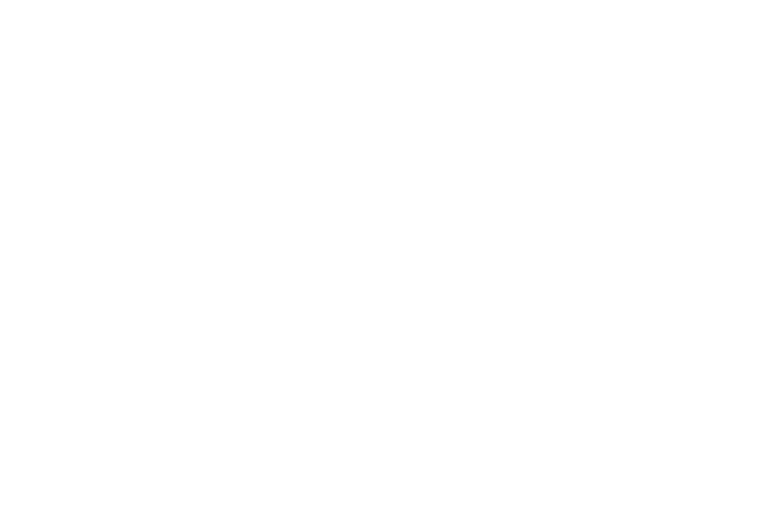

In [16]:
# for each borough do linreg to predict next year
slopes = []
for i in range(0,num_rows):
    ys = pp_dwell[years].iloc[i].tolist()
    xs = range(len(ys))
    slope, _, _, _, _ = linregress(xs, ys)
    slopes.append(slope)
    plt.plot(pp_dwell[years].iloc[i])

# extract the values for 2015 and add the predicted values
old2015s = pp_dwell['2015'].tolist()
predicted2016 = [sum(x) for x in zip(old2015s, slopes)]

# add the predicted year to the dataset
pp_dwell['2016'] = pd.Series(predicted2016, index=pp_dwell.index)

The same is done for the '2016.1' column.

In [17]:
slopes = []
for i in range(0,num_rows):
    ys = pp_dwell[years2].iloc[i].tolist()
    xs = range(len(ys))
    slope, _, _, _, _ = linregress(xs, ys)
    slopes.append(slope)
    plt.plot(pp_dwell[years2].iloc[i])

# extract the values for 2015.1 and add the predicted values
old2015s = pp_dwell['2015.1'].tolist()
predicted2016 = [sum(x) for x in zip(old2015s, slopes)]


# add the predicted year to the dataset
pp_dwell['2016.1'] = pd.Series(predicted2016, index=pp_dwell.index)

We have chosen to focus on the years 2013-2016 and we will now prepare the list we use to index into the dwellings dataframe. We use the `isin()` method to make sure that we only include the *Inner London* boroughs.

In [18]:
wanted_columns = ['Local Authority']
wanted_columns += ['2013', '2014', '2015', '2016']
wanted_columns += ['2013.1', '2014.1', '2015.1', '2016.1']


# remove 'outer' authorities and reduce to years 2013-2016
pp_dwell = pp_dwell[pp_dwell['Local Authority'].isin(list(areas.keys()))]
pp_dwell = pp_dwell[wanted_columns]

One last thing before the processed dataset is saved is to add the square area in km column to the dataset.

In [19]:
# add square area to the dataset
area_sqkm = []
for _, row in pp_dwell.iterrows():
    area_sqkm.append(areas[row['Local Authority']])
    print(row['Local Authority'], areas[row['Local Authority']])

pp_dwell['Square_Area'] = pd.Series(area_sqkm, index=pp_dwell.index)

pp_dwell.to_csv('dwellings-with-areas-processed.csv')

('City of London', 2.9007888)
('Camden', 21.755916)
('Greenwich', 47.3450172)
('Hackney', 19.0623264)
('Hammersmith and Fulham', 16.3946367)
('Islington', 14.866542599999999)
('Kensington and Chelsea', 12.121153199999998)
('Lambeth', 26.832296399999997)
('Lewisham', 35.146164299999995)
('Southwark', 28.8524886)
('Tower Hamlets', 19.761623699999998)
('Wandsworth', 34.2655677)
('Westminster', 21.471017099999997)


### 2.5 Dwelling statistics
Now we are ready for analysis and preparation of the dwelling statistics datasets. We will combine the dwelling data that we processed before, with the fire incident data.

In [20]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
import numpy as np

filenames = {
        'combined-res': 'incidents-all-boroughs-res-scaled.csv',
        'combined-dwell': 'incidents-all-boroughs-dwell-scaled.csv',
}

dwell = pd.read_csv("../data/dwellings-with-areas-processed.csv") # no. dwellings difference pr. year
firedf = pd.read_csv("../data/final_dataset.csv.bz2")

We prepare some counters, and because some of the fields are either upper-case or capitalized we will need to make sure they are all the same case. We chose to lower-case them all.

In [21]:
authorities = list(map(str.lower, dwell['Local Authority'].tolist()))
print(authorities)

# total incidents for all years 2013-2016 for each borough
totalincidents = defaultdict(int)

# count total number of incidents in each group
groupcount = defaultdict(int)

# count incidents in each group for each borough
incidentcount = defaultdict(lambda : defaultdict(int))

# lower-case all boroughs, some are upper-case and will be hashed differently
for _, row in firedf.iterrows():
    totalincidents[row['IncGeo_BoroughName'].lower()] += 1
    groupcount[row['IncidentGroup'].lower()] += 1
    incidentcount[row['IncGeo_BoroughName'].lower()][row['IncidentGroup'].lower()] += 1

['city of london', 'camden', 'greenwich', 'hackney', 'hammersmith and fulham', 'islington', 'kensington and chelsea', 'lambeth', 'lewisham', 'southwark', 'tower hamlets', 'wandsworth', 'westminster']


Now we extract data from the counters and prepare it for plotting.

In [22]:
# prepare lists for plotting
residents_per_area, labels, incidents = [], [], []
fire, special, falsealarm = [], [], []
for _, row in dwell.iterrows():
    borough = row['Local Authority'].lower()
    # residents per area is the no. of residents in 2016 / sq. area
    res_pr_area =  row['2016.1'] / row['Square_Area']
    # number of dwellings per area
    dwell_pr_area = row['2016.1'] / row['2016'] / row['Square_Area']

    residents_per_area.append(res_pr_area)
    labels.append(borough)

    # count and scale
    if borough in totalincidents:
        incidentcount[borough]['total_scaled_res'] = totalincidents[borough] / res_pr_area
        incidentcount[borough]['fire_scaled_res'] = incidentcount[borough]['fire'] / res_pr_area
        incidentcount[borough]['special_scaled_res'] = incidentcount[borough]['special service'] / res_pr_area
        incidentcount[borough]['false_scaled_res'] = incidentcount[borough]['false alarm'] / res_pr_area
        incidentcount[borough]['total_scaled_dwell'] = totalincidents[borough] / dwell_pr_area
        incidentcount[borough]['fire_scaled_dwell'] = incidentcount[borough]['fire'] / dwell_pr_area
        incidentcount[borough]['special_scaled_dwell'] = incidentcount[borough]['special service'] / dwell_pr_area
        incidentcount[borough]['false_scaled_dwell'] = incidentcount[borough]['false alarm'] / dwell_pr_area
        incidents.append(totalincidents[borough] / res_pr_area)
        fire.append(incidentcount[borough]['fire'] / res_pr_area)
        special.append(incidentcount[borough]['special service'] / res_pr_area)
        falsealarm.append(incidentcount[borough]['false alarm'] / res_pr_area)
    else:
        # in case key is nonexistant
        incidents.append(0)
        fire.append(0)
        special.append(0)
        falsealarm.append(0)

print('Done')

Done


Let us produce a grouped bar plot of all the boroughs that we are investigating. The bars are scaled by the number of residents in each area.

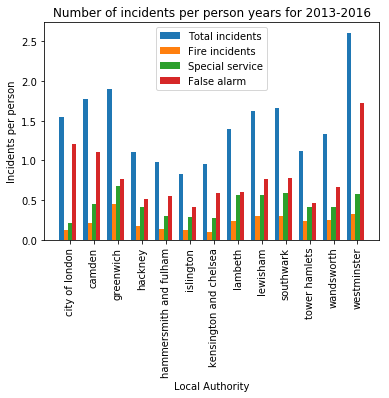

In [23]:
#  plot the results
nplots = 4
loc = np.arange(len(labels))
bw = 0.70/nplots
plt.clf()
plt.figure(1)
plt.title('Number of incidents per person years for 2013-2016')
plt.xticks(loc+2*bw, labels, rotation='vertical')
plt.bar(loc+0*bw, incidents, bw, label='Total incidents')
plt.bar(loc+1*bw, fire, bw, label='Fire incidents')
plt.bar(loc+2*bw, special, bw, label='Special service')
plt.bar(loc+3*bw, falsealarm, bw, label='False alarm')
plt.ylabel('Incidents per person')
plt.xlabel('Local Authority')
plt.legend()

We write the produced plot data to some CSV files, so that we can use them for the website. The first datasets are for all the boroughs combined, scaled by either the number of residents or the number of dwellings for each borough.

In [24]:
# Write the combined dataset file (residents_per_area)
with open(filenames['combined-res'], 'w') as f:
    w = csv.writer(f)
    w.writerow(['Borough', 'Total', 'Fire', 'Special', 'False'])
    for b in authorities:
        w.writerow([b,
                    incidentcount[b]['total_scaled_res'],
                    incidentcount[b]['fire_scaled_res'],
                    incidentcount[b]['special_scaled_res'],
                    incidentcount[b]['false_scaled_res']
                    ])

# Write the combined dataset file (dwellings_pr_area)
with open(filenames['combined-dwell'], 'w') as f:
    w = csv.writer(f)
    w.writerow(['Borough', 'Total', 'Fire', 'Special', 'False'])
    for b in authorities:
        w.writerow([b,
                    incidentcount[b]['total_scaled_dwell'],
                    incidentcount[b]['fire_scaled_dwell'],
                    incidentcount[b]['special_scaled_dwell'],
                    incidentcount[b]['false_scaled_dwell']
                    ])

Next in the process is producing plot data for each of the boroughs.

In [25]:
# prepare the filenames replace spaces in filenames
res_files = {s: s.replace(' ', '_') + '-res.csv' for s in authorities}
filenames.update(res_files)

# write a separate data file for each borough
for b in authorities:
    with open(filenames[b], 'w') as f:
        w = csv.writer(f)
        w.writerow(['Borough', 'Total', 'Fire', 'Special', 'False'])
        w.writerow([b,
                    incidentcount[b]['total_scaled_res'],
                    incidentcount[b]['fire_scaled_res'],
                    incidentcount[b]['special_scaled_res'],
                    incidentcount[b]['false_scaled_res']
                    ])

It could be fun to see if there is some correlation between the average temperature of each month and the number of indicents. For this we will use the fire data combined with the dwelling data. First we find the average temperature for each month while finding the number of incidents.

In [26]:
# -2000.0 degrees celsius is likely an error, discard those observations
tempsdf = firedf[firedf['average_temp'] > -2000.0]

# convert all the dates to datetime objects
tempsdf["DateOfCall"] = pd.to_datetime(firedf["DateOfCall"],
        format="%Y%m%d",
        infer_datetime_format=True)

# prepare counters
temps = defaultdict(int)
calls = defaultdict(int)
for _, r in tempsdf.iterrows():
    date = r['DateOfCall']
    calls[(date.year, date.month)] += 1

dates = list(calls.keys())
counts = list(calls.values())

for d in dates:
    # locate all observations for the given year,month
    df = tempsdf.loc[(tempsdf['DateOfCall'].dt.year == d[0]) & (tempsdf['DateOfCall'].dt.month == d[1])]
    temps[d] = df['average_temp'].mean()

/Users/ArpeLarpe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now we extract the average temperatures and the number of incidents as lists, so that they can be used for plotting.
We scale them with the same function that we used in the first assignment so that each $y$-value will be $y\in[0;1]$. This is done so that it is easier to compare the two graphs (incident count is a couple of thousands, while the average temperature is typically below 20 degrees celsius).

In [27]:
from __future__ import division # we need floating point division!
temps_list = [temps[d] for d in dates]

# scale the lists, since they are far apart domain-wise
scaled_counts = [(x - min(counts)) / (max(counts)-min(counts)) for x in counts]
scaled_temps = [(x - min(temps_list)) / (max(temps_list)-min(temps_list)) for x in temps_list]

Let us produce a bar plot of the data!

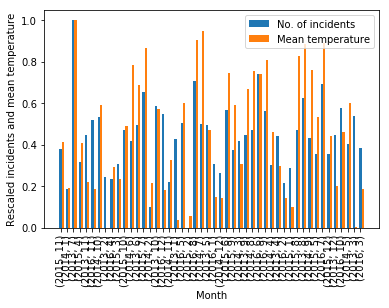

In [28]:
# Plot the findings as a beautiful bar plot
nplots = 2
loc = np.arange(len(dates))
bw = 0.70/nplots
plt.clf()
plt.figure(1)
plt.xticks(loc+0*bw, dates, rotation='vertical')
plt.bar(loc+0*bw, scaled_counts, bw, label='No. of incidents')
plt.bar(loc+1*bw, scaled_temps, bw, label='Mean temperature')
plt.ylabel('Rescaled incidents and mean temperature')
plt.xlabel('Month')
plt.legend()

There seems to be some correlation between the average temperature of the month and the number of incidents.
Lastly, we produce the neccesary CSV files for plots on the website.

In [29]:
# produce datasets for D3 visualizations
with open('../homepage/data/scaled_counts.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['Date', 'Count'])
    for i, d in enumerate(dates):
        w.writerow([d, scaled_counts[i]])

with open('../homepage/data/scaled_temps.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['Date', 'Count'])
    for i, d in enumerate(dates):
        w.writerow([d, scaled_temps[i]])

### 2.6 Dataset statistics
This section will explain some brief statistics of the dataset. 

#### Categories 
All of the incidents are either classified as fire, special incidents or False alarm. We can quickly see how they are distributed. 

<IPython.core.display.Javascript object>


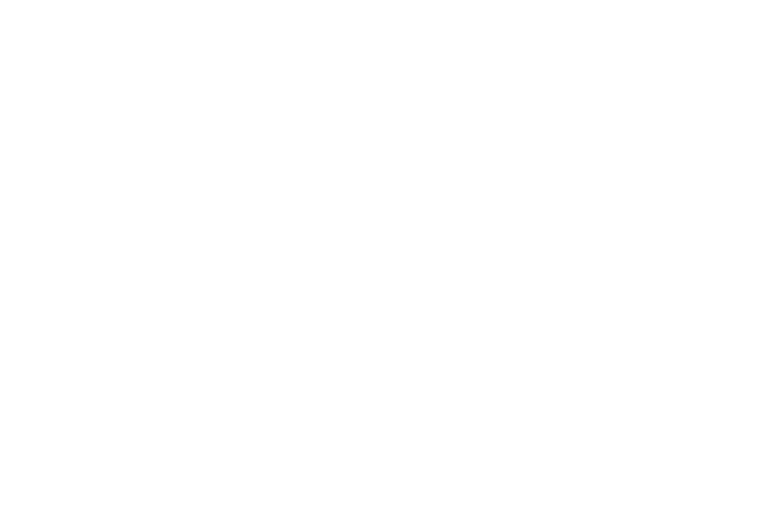

False Alarm        103328
Special Service     61739
Fire                30642
Name: IncidentGroup, dtype: int64
Total incidents: 195709


<IPython.core.display.Javascript object>


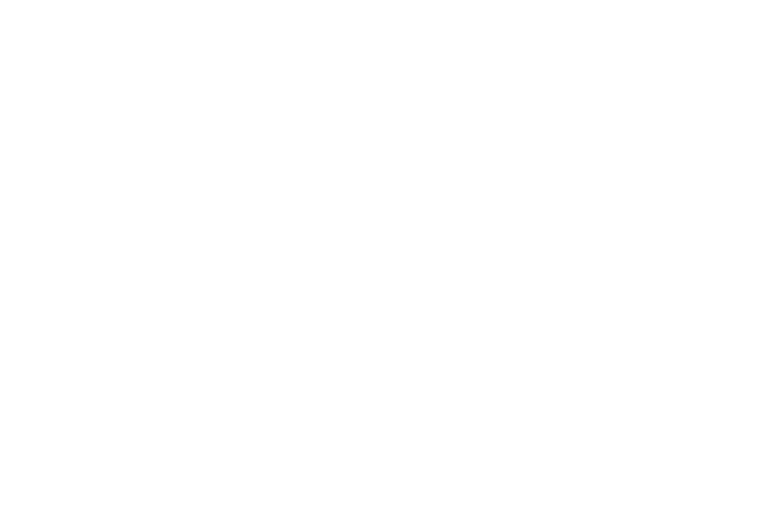

In [86]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

df = pd.read_csv("../data/dataset_final.csv",header=0)

value_counts = df["IncidentGroup"].value_counts()
value_counts.plot(kind="bar")
plt.show()
print value_counts
print "Total incidents: {0}".format(len(df))

We can here see that the data contains a majority of false alarms. It is very important to take this into consideration if we decide to create classifiers that are trying to predict which incident we are talking about. 

#### Number of incidents vs Time of day
We can also look at when the incidents are happening. 

<IPython.core.display.Javascript object>


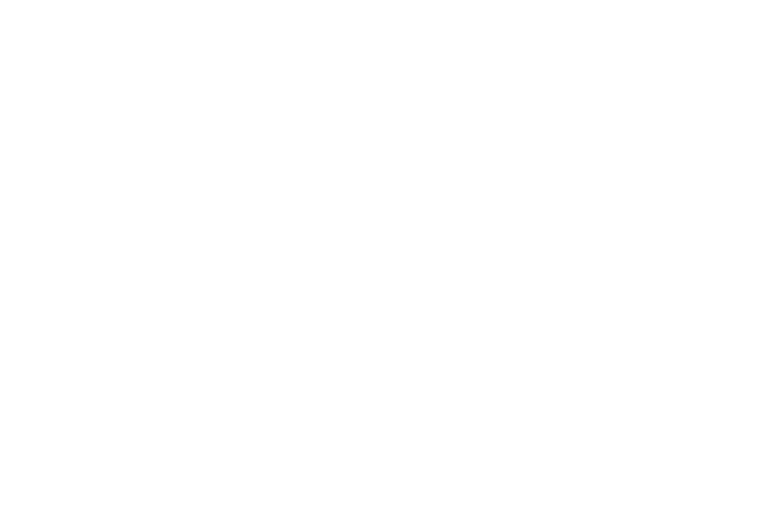

<IPython.core.display.Javascript object>


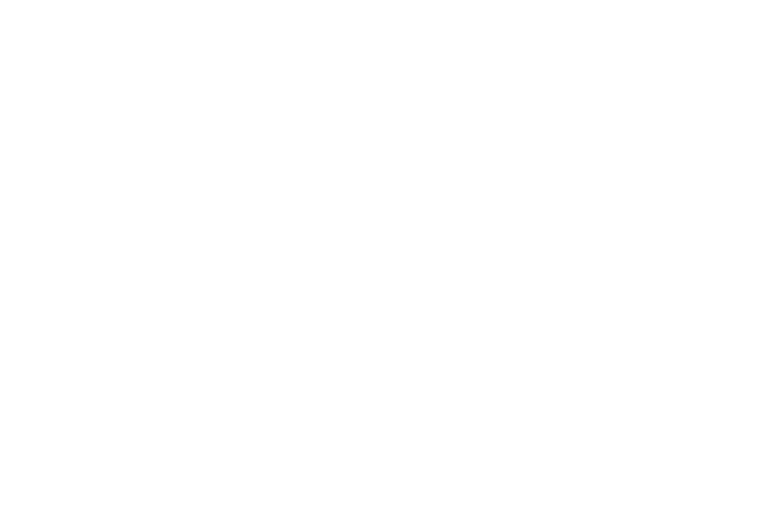

In [87]:
data = np.zeros(24)
for index, row in df.iterrows():
        time = row["TimeOfCall"][:2]
        for i in range(0,25):
            if int (time) == i:
                data[i] += 1
                break

axis = np.arange(0,24)

plt.plot(axis, data, 'ko')
plt.xlabel('Time')
plt.ylabel("Count")
plt.show()


We see that the number of incidents is linearly increasing from 5-19 and linear decreasing from 20-5 which is very similar to how san francisco police department acted. 

#### Locations 
Let us now look at where the incidents are mostly happening. We can do this by creating a heatmap using geoplotlib. We first just show London to give the reader an idea of where we are. 

In [84]:
import geoplotlib
bbox = geoplotlib.utils.BoundingBox(north=51.600, west=-0.489, south=51.45, east=0.236)
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

bbox = geoplotlib.utils.BoundingBox(north=51.600, west=-0.489, south=51.45, east=0.236)
geoplotlib.set_bbox(bbox)
geoplotlib.kde({"lat": df["lat"],
             "lon": df["lon"]}, bw=4)
geoplotlib.inline()

('smallest non-zero count', 2.2389746227652008e-09)
('max count:', 11.402105603894029)


We see that a lot of the incidents are happening at China Town. Lets see if the heat map changes if we sort our data on the category! 

In [85]:
df_false = df[df["IncidentGroup"] == "False Alarm"]
df_fire = df[df["IncidentGroup"] == "Fire"]
df_special = df[df["IncidentGroup"] == "Special Service"]

geo_false = {"lat": df_false["lat"],
             "lon": df_false["lon"]}

geo_fire = {"lat": df_fire["lat"],
             "lon": df_fire["lon"]}

geo_special = {"lat": df_special["lat"],
             "lon": df_special["lon"]}

data_for_heat = [geo_false, geo_fire, geo_special]
for i in data_for_heat:
    bbox = geoplotlib.utils.BoundingBox(north=51.600, west=-0.489, south=51.45, east=0.236)
    geoplotlib.set_bbox(bbox)
    geoplotlib.kde(i, bw=4)
    geoplotlib.inline()
    

('smallest non-zero count', 1.1194873113826004e-09)
('max count:', 9.6211966448236765)


('smallest non-zero count', 1.1194873113826004e-09)
('max count:', 1.819973339212092)


('smallest non-zero count', 2.2389746227652008e-09)
('max count:', 2.1195039663149697)


What we see from this is that the special incidents are very spread out in Inner London while the False Alarms and actual fire incidents are still happening all over london, but more in china town than the rest. This might be because of factors regarding population density! 

## 3 - Theory
This sections aims at covering the different machine learning models and relevant theory which we have used for the analysis. 

### 3.1 K-Means 
The fire stations in Inner London serve different locations. They are placed according to a lot of different criteria which are unknown to us. However, imagine that they have to relocate and rebuild all of the fire-stations. We can here use K-means in order to do this. Since there are 57 fire stations in Inner London, we have decided to perform K-means on a subset of boroughs. The method is however easily extended to include all of London. We have chosen to use the following:  "Kensington and Chelsea", "Westminster", "Camden", and "Islington"

There are 12 fire stations serving these boroughs. Therefore we train a model with k=12 to begin with. 

In [34]:
from geoplotlib.colors import ColorMap
from sklearn.cluster import KMeans
cmap = ColorMap('tab20', alpha=255, levels=20)

df_kmeans = df[df.apply(lambda x: x["IncGeo_BoroughName"] in 
                        ["kensington and chelsea", "westminster", "camden and islington"], axis=1)]

n_clusters = 12
X = np.column_stack((df_kmeans["lat"].tolist(), df_kmeans["lon"].tolist()))

model = KMeans(n_clusters=n_clusters)
y_pred = model.fit(X)
Z = model.labels_

# Need these arrays for the plotting
lat = np.asarray([i[0] for i in X])
lon = np.asarray([i[1] for i in X])


bbox = geoplotlib.utils.BoundingBox(north=51.580, west=-0.440, south=51.49, east=0.180)

for i in range(0,n_clusters):
    predictions = {"lat" : lat[np.where(Z == i)], "lon" : lon[np.where(Z == i)]}
    geoplotlib.set_bbox(bbox)
    geoplotlib.dot(predictions, color = cmap.to_color(i, 20, 'lin'))

geoplotlib.inline()

We see here that we succesfully clustered the data in 12 new clusters using K-means. We will here use the clusters as "new" fire stations which is visualized on our webpage. We will also visualize how the current fire stations are placed and how everything is categorized. 

There are not really 12 clusters present, but rather one huge. However, we can see on the illustration that the clusters are distributed very

### 3.2 Decision Tree and Random Forest
The data has three different incident types, and we want to see whether we can predict which type we have based on the data we have available. To do this, we will try using a decision tree and a random forest classifier (a variant of decision trees).

First we will extract a dataset consisting of the relevant attributes. We suspect that it matters whether it is weekend or week. So we create the binary attribute time_of_week. Furthermore, we suspect it matters whether it is night or day hence we create the attribute time_of_day. At last we will use information about dwellings in the different boroughs depending on the years, attendence time, and time it takes to get there. 

In [52]:
import time
from datetime import datetime

# DateOfCall --> Translate to month, week, day
def convert_date_to_year_month_day(date):
    year = int(date[0:4])
    month = int(date[4:6])
    day = int(date[6:8])

    return year, month, datetime(year, month, day).weekday()

# Instead of precise time, we use hourly intervals
def convert_time_to_binary(time_yo):
    current_time = int(time_yo[0:2])
    
    # Night
    if current_time < 5 or current_time > 20:
        return 0
    
    # day
    return 1

df = pd.read_csv("../data/dataset_final.csv", header=0)

# check how many of each type
print df['IncidentGroup'].value_counts()

# Load the dwelling data
df_dwelling = pd.read_csv("../data/dwellings-with-areas-processed.csv", header=0)
df_dwelling["Local Authority"] = df_dwelling.apply(lambda x: x["Local Authority"].lower(), axis=1)

False Alarm        103328
Special Service     61739
Fire                30642
Name: IncidentGroup, dtype: int64


In [53]:
# Information which we want
day = []
month = []
year = []
time = []
citizen_pr_dwelling = []
total_citizens = []
area_size = []

for index, row in df.iterrows():
    cur_year, cur_month, cur_day = convert_date_to_year_month_day(str(row["DateOfCall"]))
    
    # Weekend
    if cur_day == 5 or cur_day == 6:
        day.append(0)
    # day
    else:
        day.append(1)
    
    month.append(cur_month)
    year.append(cur_year)

    time.append(convert_time_to_binary(row["TimeOfCall"]))

    for index1, row1 in df_dwelling.iterrows():
        if row1["Local Authority"] == row["IncGeo_BoroughName"]:
            if cur_year == 2013:
                citizen_pr_dwelling.append(row1["2013"])
                total_citizens.append(row1["2013.1"])
                area_size.append(row1["Square_Area"])
            elif cur_year == 2014:
                citizen_pr_dwelling.append(row1["2014"])
                total_citizens.append(row1["2014.1"])
                area_size.append(row1["Square_Area"])
            elif cur_year == 2015:
                citizen_pr_dwelling.append(row1["2015"])
                total_citizens.append(row1["2015.1"])
                area_size.append(row1["Square_Area"])
            elif cur_year == 2016:
                citizen_pr_dwelling.append(row1["2016"])
                total_citizens.append(row1["2016.1"])
                area_size.append(row1["Square_Area"])

# Drop the attributes which we dont care about
relevant_attributes = ["IncidentGroup","FirstPumpArriving_AttendanceTime", "average_temp", 
                       "time_from_call_to_arrive", "euclidian_distance_to_fire_station"]

df_decision = df
df_decision.drop([col for col in df_decision.columns if col not in relevant_attributes], axis=1, inplace=True)

df_decision["citizen_pr_dwelling"] = np.nan
df_decision["citizen_pr_dwelling"] = pd.Series(citizen_pr_dwelling, index=df_decision.index)
df_decision["total_citizens"] = np.nan
df_decision["total_citizens"] = pd.Series(total_citizens, index=df_decision.index)
df_decision["area_size"] = np.nan
df_decision["area_size"] = pd.Series(area_size, index=df_decision.index)
df_decision["day"] = np.nan
df_decision["day"] = pd.Series(day, index=df_decision.index)
df_decision["time"] = np.nan
df_decision["time"] = pd.Series(time, index=df_decision.index)

We will have to map the type of incidents to an integer which is obtained by creating a dictionary. Furthermore, we cannot use rows from our data that does not have a time form call to arrive attribute hence we will remove those. Furthermore, we perform a "cheat" where we substitute values without an attendance time with the mean of all attendance times. 

In [54]:
# Map the incidentgroup to an integer for the model
types = df_decision["IncidentGroup"].unique()
values_types = np.arange(0, len(types)+1)
type_to_value = dict(zip(types, values_types))
value_to_type = dict(zip(types, values_types))

df_decision["IncidentGroup"] = df_decision.apply(lambda  x: type_to_value[x["IncidentGroup"]], axis=1)

In [55]:
# Remove values with no time from call to arrive
df_decision = df_decision[df_decision.apply(lambda x: (not pd.isnull(x["time_from_call_to_arrive"])), axis=1)]
print len(df_decision)


print df_decision["FirstPumpArriving_AttendanceTime"].isnull().sum().sum()
df_decision["FirstPumpArriving_AttendanceTime"].\
    fillna(df_decision["FirstPumpArriving_AttendanceTime"].mean(), inplace=True)
    

184639
12762


There is a majority of special incidents, so we perform under-sampling in order to take this into consideration

In [56]:
# I know minimum is fire which is 30652
sample_size = len(df_decision[df_decision["IncidentGroup"] == 1])

# Minimum is fire
fire_indices = df_decision[df_decision["IncidentGroup"] == 1].index
fire_sample = df_decision.loc[fire_indices]

# False alarms
false_indices = df_decision[df_decision["IncidentGroup"] == 0].index
false_random_indices = np.random.choice(false_indices, sample_size, replace=False)
false_sample = df_decision.loc[false_random_indices]

# Special
special_indices = df_decision[df_decision["IncidentGroup"] == 2].index
special_random_indices = np.random.choice(special_indices, sample_size, replace=False)
special_sample = df_decision.loc[special_random_indices]

merged_sample = pd.concat([special_sample, fire_sample, false_sample], ignore_index=True)

We are not ready to train the classifier. 

In [57]:
from sklearn.tree import DecisionTreeClassifier
model_tree_multi = DecisionTreeClassifier()
from sklearn.model_selection import train_test_split
import json

np.random.seed(1337)

In [58]:
# Features to consider
features = ['day', 'time','average_temp', "FirstPumpArriving_AttendanceTime",
            "time_from_call_to_arrive",'citizen_pr_dwelling', 'total_citizens', 'area_size']

We split the dataset into a training and a test set. 

In [59]:
train, test = train_test_split(df_decision, test_size = 0.2)

y_train = train['IncidentGroup']
X_train = train[features]

y_test = test['IncidentGroup']
X_test = test[features]


We evaluate different models by training with different max depths.

In [60]:
#Test max depth
best_score = 0
best_max_depth = 0

for i in range(3,20):
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)

    test_score = dt.score(X_test, y_test)

    #print "Max depth: {0}".format(i)
    #print "Fraction of correct predictions train: {0}".format(dt.score(X_train, y_train))
    #print "Fraction of correct predictions test: {0}".format(test_score)

    if test_score > best_score:
        best_max_depth = i
        best_score = test_score


print "Best Max Depth: {0}".format(best_max_depth)
print "Fraction of correct predictions test (best): {0}".format(best_score)


Best Max Depth: 7
Fraction of correct predictions test (best): 0.598028596187


We obtain a best score with max depth set to 7. However, when visualizing a decision tree, this is quite deep. We therefore set it to 5 instead. 

In [61]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

test_score = dt.score(X_test, y_test)
print "Fraction of correct predictions test (depth=5): {0}".format(test_score)

from sklearn import tree
tree.export_graphviz(dt, out_file='tree.dot', feature_names=features)
from subprocess import check_call
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])

Fraction of correct predictions test (depth=5): 0.594941507799


0

We actually get almost the same accuracy as with the best max depth. We can visualize the tree as seen below.

<img src="tree.png">

We now need to save our model in a format that we can visualize with d3. This is done below using a method found on the web. Credits to: https://github.com/ajschumacher/ajschumacher.github.io/blob/master/20151129-see_sklearn_trees_with_d3/index.md

We then dump the decision tree information in a json format.

In [62]:
def rules(clf, features, labels, node_index=0):
    """Structure of rules in a fit decision tree classifier

    Parameters
    ----------
    clf : DecisionTreeClassifier
        A tree that has already been fit.

    features, labels : lists of str
        The names of the features and labels, respectively.

    """
    node = {}
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        count_labels = zip(clf.tree_.value[node_index, 0], labels)
        node['name'] = ', '.join(('{} of {}'.format(int(count), label)
                                  for count, label in count_labels))
    else:
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        node['name'] = '{} > {}'.format(feature, threshold)
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        node['children'] = [rules(clf, features, labels, right_index),
                            rules(clf, features, labels, left_index)]
    return node
['day', 'time','average_temp', "FirstPumpArriving_AttendanceTime",
            "time_from_call_to_arrive",'citizen_pr_dwelling', 'total_citizens', 'area_size']
features_for_d3 = ['night/day', 'weekend/week','temperature', "Attendance time",
            "time to arrive", "citizens pr dwelling", "total_citizens", "area size"]

r = rules(dt, features_for_d3, ["Fire", "Special Service", "False Alarm"])
with open('../data/rules.json', 'w') as f:
    f.write(json.dumps(r))


We can also train a more complex desicion tree model such as a random forest to see whether we get an improved performance

In [63]:
from sklearn.ensemble import RandomForestClassifier
dt = RandomForestClassifier(n_estimators=100, max_leaf_nodes=4)
dt.fit(X_train, y_train)

print "Fraction of correct predictions train: {0}".format(dt.score(X_train, y_train))
print "Fraction of correct predictions test: {0}".format(dt.score(X_test, y_test))


Fraction of correct predictions train: 0.562700137431
Fraction of correct predictions test: 0.561687608319


Performing a grid-search with different parameters with the model we would probably be able to obtain a higer accuracy. However, it is very hard to visualize a random forest model, so we decided just to use the simple desicion tree. 

### 3.2 Multiple Linear Regression
We thought that the time taken to arrive at a location is dependant on the euclidian distance. Furthermore, we thought that it should be dependant on the temperature i.e. when its very cold and snowy, they have to drive more safe. Therefore, it was obvious to fit a multiple linear regression model to predict the arrival time. 

First we delete incidents without arrival time.

In [64]:
print list(df_decision)

# Delete incidents without arrival time
df_decision = df_decision[df_decision.apply(lambda x: (not pd.isnull(x["time_from_call_to_arrive"])), axis=1)]


['IncidentGroup', 'FirstPumpArriving_AttendanceTime', 'time_from_call_to_arrive', 'average_temp', 'euclidian_distance_to_fire_station', 'citizen_pr_dwelling', 'total_citizens', 'area_size', 'day', 'time']


Next we create a training and a test set with a 80/20 split.

In [65]:
features = ['average_temp',
            "euclidian_distance_to_fire_station"]

train, test = train_test_split(df_decision, test_size = 0.2)

y_train = train['time_from_call_to_arrive']
X_train = train[features]

y_test = test['time_from_call_to_arrive']
X_test = test[features]


We normalize the training/test features so that they have mean 0. 

In [66]:
X_train = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.mean()) / (X_test.max() - X_test.min())

X_train = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.mean()) / (X_test.max() - X_test.min())

Now we are ready to train the model.

In [67]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

print "Model coefficians:"
print model.coef_
print "Model intercept:"
print model.intercept_


print "r^2 error: {0}".format(model.score(X_train, y_train))
print "r^2 error: {0}".format(model.score(X_test, y_test))


Model coefficians:
[ 0.11728647  5.10977441]
Model intercept:
5.68458002451
r^2 error: 0.0450064010435
r^2 error: 0.0481529526971


The coeficians and the intercept is enough in order to predict the arrival time given the distance from nearest fire station and the temperature. Note that the r squared error does not really give a nice estimate towards model performance. Instead we print the first 6 classifications against the actual ones from the test data. We can use the printed data on our website to visualize the model.

In [68]:
Z = model.predict(X_test)
print len(Z)

print Z[:10]
counter = 0
for index, item in y_test.iteritems():
    print "Prediction: {0}, Actual: {1}".format(Z[counter], item)
    counter += 1
    if counter == 6:
        break


36928
[ 4.5081115   6.24850471  4.72009839  5.71598336  4.79280015  5.94945109
  6.91657653  5.3483031   6.41572749  5.77544101]
Prediction: 4.50811149556, Actual: 10.0
Prediction: 6.24850471014, Actual: 6.0
Prediction: 4.72009839216, Actual: 7.0
Prediction: 5.71598335744, Actual: 8.0
Prediction: 4.79280015337, Actual: 5.0
Prediction: 5.94945108781, Actual: 4.0


In ost cases the model does not seem that much off, but certainly could be improved! However, it is expected that the arrival time is dependant on the euclidian distance and the temperature, but mostly other factors matter. The euclidian distance also does not mean that there is a nice route to the incident. 

## 4 - Visualizations
We have chosen 5 different visualizations for the webpage. We want to tell a story where we first explore the data to see some stastics both at borrow level and what we else find relevant. Then we show how different machine learning models can be used in order to help improve the London Fire Brigade.


### 4.1 Spurious correlation
We found a pretty fun correlation between the temperature and fire incidents. This is a fun way of illustrating a spurious correlation

### 4.2 Informative interactive barplot 
We scaled the types on the residents at borough level. We chose this visualization to give an overview of the data.


### 4.3 K-means
We included a a fun way to illustrate the power of machine learning.

### 4.4 Desicion Tree
Visualizing the factors that matters depending on the different classification types.

### 4.5 Multiple Linear Regression
Even though the regression is very dependent on the euclidian distance, we still though it was interesting to visualize estimates for arrival times in Inner London.

## 5 - Discussion 
We succesfully did a data analysis on a new, unexplored dataset. We used different machine learning teqhniques learned during the course
and visualized it in d3 on our webpage. 

We used a lot of time during pre-processing in order to get as much data as possible. We hoped that more data would result in better visualizations. 

Initially we thought that we could find a lot of cool correlations in our data that would result in usefull visualizations which the LFB could use. After trying out a lot of different methods, we did not really find anything that was new 

If we had more time, we would have used more data and perhaps be able to explain when fires occur. Perhaps more data would not have helped, as the incidents seem to occur randomly during the day. 

We could also have included even more data as the LFB provides data that dates back to 2009. However, we assumed that the data would be very similar to what we used. Including more data would then just result in slower computations. 

Overall we did a data analysis with new interesting data, where we were able to perform some nice visualizations telling a story of how the LFB can use their data. We do however not expect to be hired as data consultants by the LFB! :) 